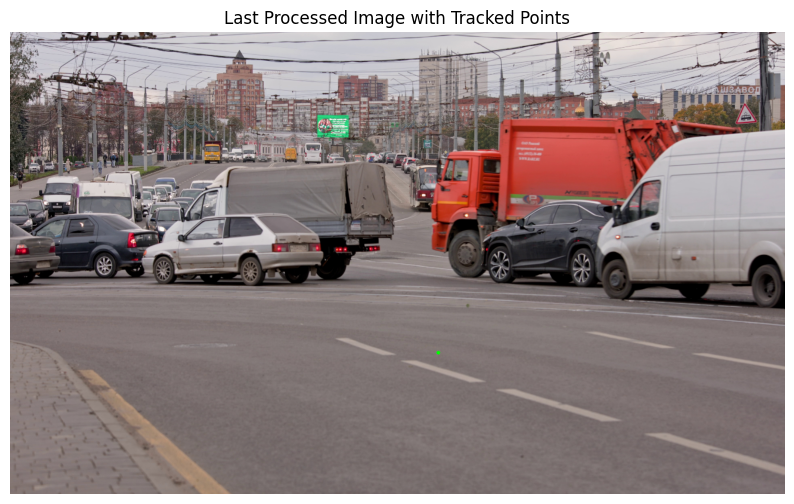

Lucas–Kanade tracking completed successfully.


In [ ]:
import cv2
import numpy as np
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt

ZIP_PATH = "/content/archive.zip"   # your uploaded file

# ---- Extract images to temporary folder ----
temp_dir = Path("/mnt/data/temp_frames")
temp_dir.mkdir(exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(temp_dir)

# Collect frames
images = sorted([str(p) for p in temp_dir.rglob("*")
                 if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])

if len(images) < 2:
    raise Exception("Not enough image frames in the ZIP!")

# ---- Read the first frame ----
prev_img = cv2.imread(images[0])
prev_gray = cv2.cvtColor(prev_img, cv2.COLOR_BGR2GRAY)

# Get the reference size from the first image
ref_height, ref_width = prev_gray.shape

# Detect initial points
prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200,
                                   qualityLevel=0.01, minDistance=7)

lk_params = dict(winSize=(21,21), maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

# ---- Process each next frame ----
for path in images[1:]:
    img = cv2.imread(path)

    # Check if the current image has different dimensions and resize if necessary
    if img.shape[0] != ref_height or img.shape[1] != ref_width:
        img = cv2.resize(img, (ref_width, ref_height))

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # optical flow
    next_pts, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_pts, None, **lk_params)

    good_new = next_pts[status == 1]
    good_old = prev_pts[status == 1]

    # ---- Visualization (optional) ----
    for (new, old) in zip(good_new, good_old):
        a, b = new.ravel()
        img = cv2.circle(img, (int(a), int(b)), 3, (0,255,0), -1)

    # show the frame (optional)
    # cv2.imshow("Tracking", img)
    # if cv2.waitKey(30) == 27:
    #     break

    # update
    prev_gray = gray.copy()
    prev_pts = good_new.reshape(-1, 1, 2)

# cv2.destroyAllWindows()

# Display the final image with tracked points
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Last Processed Image with Tracked Points")
plt.axis('off')
plt.show()

print("Lucas–Kanade tracking completed successfully.")